### Sustained Attention Response Time (SART) task ERP analysis: signal pre-processing
EEG signal filtering, artefact rejection, and segmenting based on the events.

In [1]:
# Import packages
import mne, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from autoreject import (get_rejection_threshold, AutoReject)

# Set the default directory
os.chdir('/Users/aliciacampbell/Documents/GitHub/EEG-pyline')
mne.set_log_level('error')

# Import functions
import signal_processing.pre_process as prep
import basic.arrange_data as arrange

Define these variables!

In [2]:
# Folder where to get the raw EEG files
raw_folder = 'Data/Raw/'

# Folder where to export the clean epochs files
clean_folder = 'Data/Clean/'

# Folder where to save the results and plots
results_folder = 'Results/'

# Sub-folder for the experiment (i.e. timepoint or group)
exp_folder = 'LEISURE/T3/SART/'
exp_condition = 'SART_T3'

# EOG + mastoid channels and stimulus channel
eog_channels = ['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8']
stimulus_channel = 'Status'

wrong_mnt_chs = ["B1","B2","B3","B4","B5","B6","B7","B8","B9","B10","B11","B12",
                "B13","B14","B15","B16","B17","B18","B19","B20","B21","B22","B23","B24",
                "B25","B26","B27","B28","B29","B30","B31","B32",
                "C1","C2","C3-1","C4-1","C5","C6","C7","C8","C9","C10","C11","C12",
                "C13","C14","C15","C16","C17","C18","C19","C20","C21","C22","C23","C24",
                "C25","C26","C27","C28","C29","C30","C31","C32",
                "D1","D2","D3","D4","D5","D6","D7","D8","D9","D10","D11","D12",
                "D13","D14","D15","D16","D17","D18","D19","D20","D21","D22","D23","D24",
                "D25","D26","D27","D28","D29","D30","D31","D32"]

# Parameters for filter design
filter_design = dict(l_freq=1, h_freq=30, filter_length='auto', method='fir',
                     l_trans_bandwidth='auto', h_trans_bandwidth='auto',
                     phase='zero', fir_window='hamming', fir_design='firwin')

# Epoch time window from event/stimuli
tminmax = [-0.2, 1]

# Baseline correction time window
baseline_correction = None

# Event names with IDs for GO and NO-GO trials
event_dict = {'GO trial': 4,
              'NO-GO trial': 8,
              'Button press': 16}

# Button press ID
button_id = 16

Run this to set the folders for data.

In [3]:
# Get directories of raw EEG files and set export directory for clean files
dir_inprogress = os.path.join(raw_folder,exp_folder)
export_dir = os.path.join(clean_folder,exp_folder)
file_dirs, subject_names = arrange.read_files(dir_inprogress,'.bdf')

Files in Data/Raw/LEISURE/T3/SART/ read in: 2


Run this to pre-process the raw EEG files to clean epochs objects.


HBA_0109_SART_T3 (1 / 2)


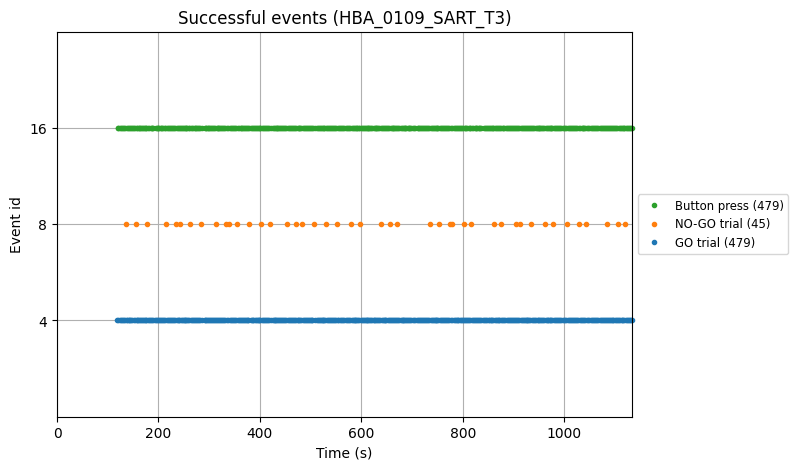


HBA_0114_SART_T3 (2 / 2)


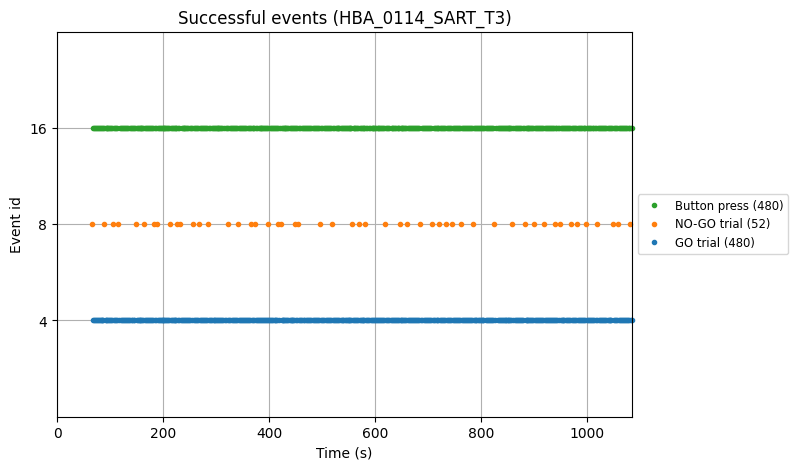

In [4]:
# Loop through all the subjects' directories (EEG files directories)
df_success = pd.DataFrame()
for i in range(len(file_dirs)):
        print('\n{} ({} / {})'.format(subject_names[i], i+1, len(file_dirs)))
        # Read in the raw EEG data
        try:
                raw = mne.io.read_raw_bdf(file_dirs[i], infer_types=True, eog=eog_channels,
                                        stim_channel=stimulus_channel).drop_channels(['Erg1'])
        except:
                raw = mne.io.read_raw_bdf(file_dirs[i], infer_types=True, eog=eog_channels,
                                        stim_channel=stimulus_channel)
                
        if len(set(wrong_mnt_chs).intersection(set(raw.info['ch_names']))) > 0:
                print('wrong montage, removing bad channels and replacing some channel names..')
                raw = raw.drop_channels(wrong_mnt_chs).rename_channels({'C3-0':'C3','C4-0':'C4'})

        # Set the right montage (Biosemi32) and set reference as average across all channels
        raw = raw.set_montage(mne.channels.make_standard_montage('biosemi32')).load_data()\
                 .set_eeg_reference(ref_channels='average', verbose=False)
    
        # Filter the signal with bandpass filter and remove EOG artefacts with SSP
        filt = prep.filter_raw_data(raw, filter_design, line_remove=None, eog_channels=eog_channels,
                                    plot_filt=False, savefig=False, verbose=False)
        
        # Find events from the filtered EEG data and name them
        events = mne.find_events(filt, stim_channel=stimulus_channel, consecutive=False, output='onset')
        
        # Create an array and dataframe of successful GO (followed with button press) and NO-GO trials (no button press)
        success_events_total = []
        success_go = []
        unsuccess_nogo = []
        df_success_temp = pd.DataFrame(index=[subject_names[i]],
                                       data={'Total GO' : np.sum(events[:, 2] == event_dict['GO trial']),
                                             'Total NO-GO' : np.sum(events[:, 2] == event_dict['NO-GO trial']),
                                             'Correct GO': 0, 'Correct NO-GO': 0,
                                             'Incorrect GO': 0, 'Incorrect NO-GO': 0})
        # Go through all events to check if they were successful or not
        for m in range(len(events)):
                # If event is a GO, check for button press
                if events[m][2] == event_dict['GO trial']:
                        if events[m+1][2] == button_id:
                                # If there is a button press -> success
                                success_events_total.append(events[m])
                                success_events_total.append(events[m+1])
                                success_go.append(events[m])
                                success_go.append(events[m+1])
                                df_success_temp['Correct GO'] += 1
                        else:
                                # If there is no button press -> fail
                                df_success_temp['Incorrect GO'] += 1
                # If event is a NO-GO, check for no button press
                if events[m][2] == event_dict['NO-GO trial']:
                        if events[m+1][2] != button_id:
                                # If there is no button press -> success
                                success_events_total.append(events[m])
                                df_success_temp['Correct NO-GO'] += 1
                        else:
                                # If there is a button press -> fail
                                unsuccess_nogo.append(events[m])
                                unsuccess_nogo.append(events[m+1])
                                df_success_temp['Incorrect NO-GO'] += 1
        success_events_total = np.asarray(success_events_total)
        success_go = np.asarray(success_go)
        unsuccess_nogo = np.asarray(unsuccess_nogo)

        # Calculate response times to button press for correct GO and incorrect NO-GO
        if len(success_go)!=0:
                rt_go = np.diff(success_go[:, 0])[0::2]/raw.info['sfreq']
        else:
                rt_go = 0
        if len(unsuccess_nogo)!=0:
                rt_nogo = np.diff(unsuccess_nogo[:, 0])[0::2]/raw.info['sfreq']
        else:
                rt_nogo = 0

        # Calculate descriptives for these response times
        df_success_temp['Average RT (Correct GO)'] = np.mean(rt_go)
        df_success_temp['Average RT (Incorrect NO-GO)'] = np.mean(rt_nogo)
        df_success_temp['SD RT (Correct GO)'] = np.std(rt_go)
        df_success_temp['SD RT (Incorrect NO-GO)'] = np.std(rt_nogo)
        df_success_temp['Median RT (Correct GO)'] = np.median(rt_go)
        df_success_temp['Median RT (Incorrect NO-GO)'] = np.median(rt_nogo)
        df_success_temp['Minimum RT (Correct GO)'] = np.min(rt_go)
        df_success_temp['Minimum RT (Incorrect NO-GO)'] = np.min(rt_nogo)
        df_success_temp['Maximum RT (Correct GO)'] = np.max(rt_go)
        df_success_temp['Maximum RT (Incorrect NO-GO)'] = np.max(rt_nogo)
        df_success_temp['RTs (Correct GO)'] = str(rt_go)
        df_success_temp['RTs (Incorrect NO-GO)'] = str(rt_nogo)

        # Merge the participant dataframe with the master dataframe
        df_success = pd.concat([df_success, df_success_temp])

        # Plot all the events
        %matplotlib inline
        fig, axs = plt.subplots(1, 1, figsize=(10, 5))
        fig = mne.viz.plot_events(success_events_total, sfreq=filt.info['sfreq'],
                                  first_samp=filt.first_samp, event_id=event_dict,
                                  axes=axs, show=False)
        fig.subplots_adjust(right=0.7)
        axs.set_title('Successful events ({})'.format(subject_names[i]))
        plt.show()

        # Create epochs time-locked to successful GO and NO-GO events (without including the button press events)
        picks = mne.pick_types(filt.info, eeg=True, stim=False)
        epochs = mne.Epochs(filt, success_events_total[success_events_total[:, 2] != 16], #event_id=event_dict,
                            tmin=tminmax[0], tmax=tminmax[1], baseline=baseline_correction,
                            picks=picks, preload=True)
        
        # # Plot the epochs' GFP plot before artefact rejection
        # epochs.plot_image(title="GFP without AR ({})".format(subject_names[i]))

        # # Use AutoReject to repair and remove epochs which are artefactual
        # reject_criteria = get_rejection_threshold(epochs)
        # print('Dropping epochs with rejection threshold:',reject_criteria)
        # epochs.drop_bad(reject=reject_criteria)

        # ar = AutoReject(thresh_method='random_search', random_state=1)
        # ar.fit(epochs)
        # epochs_ar, reject_log = ar.transform(epochs, return_log=True)
        # reject_log.plot('horizontal')

        # # Plot the epochs' GFP after artefact rejection
        # epochs_ar.average().plot()
        # epochs_ar.plot_image(title="GFP with AR ({})".format(subject_names[i]))

        # # Display the final epochs object meta-data
        # display(epochs_ar)

        # # Save the cleaned EEG file as .fif file
        # try:
        #         os.makedirs(export_dir)
        # except FileExistsError:
        #         pass
        # try:
        #         mne.Epochs.save(epochs_ar, fname='{}/{}_clean-epo.fif'.format(export_dir,
        #                                                                       subject_names[i]),
        #                                                                       overwrite=True)
        # except FileExistsError:
        #         pass
        
# Save the dataframe for task performance
df_success.to_excel('{}/{}/{}_task_performance.xlsx'.format(results_folder,exp_folder,exp_condition))